### Agent-Lab: Adaptive RAG Agent

Objective of this notebook is evaluating and adapting the implementation of [Adaptive RAG Agent](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_adaptive_rag/).

#### Preparation steps:

Before executing the notebook perform the following preparation steps.

1. Start Docker containers: `docker compose up -d --build`

2. Verify application is up and running, with web browser: `http://localhost:18000/docs`

3. Inside project root directory, create a `.env` file with env vars with correct values:

    ```
    DEVELOPING="True"
    OLLAMA_ENDPOINT="http://localhost:11434"
    XAI_API_KEY="???"
    ```

---

In [1]:
%%capture

import os
os.chdir('..')

from dotenv import load_dotenv
load_dotenv()

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest


# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
# create agent
# agent = experiment_utils.create_ollama_agent(
#     agent_type="adaptive_rag",
#     llm_tag="llama3.2-vision:latest",
#     ollama_endpoint=os.getenv("OLLAMA_ENDPOINT")
#)

agent = experiment_utils.create_xai_agent(
    agent_type="adaptive_rag",
    llm_tag="grok-2",
    api_key=os.getenv("XAI_API_KEY")
)

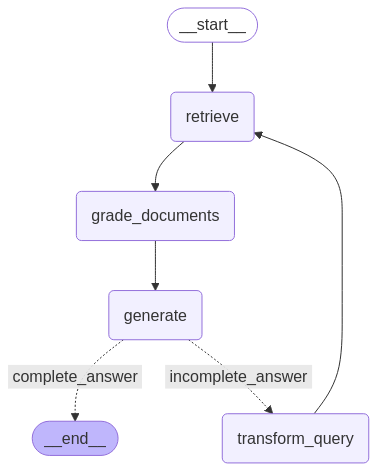

In [3]:
# get agent instance
adaptive_rag_agent = container.adaptive_rag_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# Create Graph
workflow_builder = adaptive_rag_agent.get_workflow_builder(agent["id"])
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [4]:
agent_config = {
    "configurable": {
        "thread_id": agent["id"],
    },
    "recursion_limit": 30
}

In [5]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="What is the pinnacle of excellence?",
    agent_id=agent["id"]
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [6]:
print(result['generation'])

The pinnacle of excellence, as described in the context, is to achieve victory without fighting. This involves breaking the enemy's resistance and thwarting their plans through strategic planning and minimal confrontation, thereby avoiding bloodshed and achieving a complete victory.


In [7]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Can you repeat my previous question and answer it again but this time in dutch?",
    agent_id=agent["id"]
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [8]:
print(result['generation'])

<query>Wat is de top van uitmuntendheid?</query>

De top van uitmuntendheid, zoals beschreven in de context, is om een overwinning te behalen zonder te vechten. Dit houdt in dat je het verzet van de vijand breekt en hun plannen doorkruist door middel van strategische planning en minimale confrontatie, waardoor bloedvergieten wordt vermeden en een volledige overwinning wordt bereikt.


In [9]:
%%capture

message = MessageRequest(
    message_role="human",
    message_content="Kun je mijn vorige vraag en jouw antwoord herhalen maar dit keer in het Portugees?",
    agent_id=agent["id"]
)

inputs = adaptive_rag_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)

In [10]:
print(result['generation'])

<query>Qual é o ápice da excelência?</query>

O ápice da excelência, conforme descrito no contexto, é alcançar a vitória sem lutar. Isso envolve quebrar a resistência do inimigo e frustrar seus planos por meio de planejamento estratégico e confronto mínimo, evitando assim derramamento de sangue e alcançando uma vitória completa.


In [11]:
print(f"\nMessage history as chain-of-thought:")
count = 0
for message in result['messages']:
    count+=1
    print(f"\n---\n#{count}:\n{message}")


Message history as chain-of-thought:

---
#1:
First: The human asked or stated - What is the pinnacle of excellence?
Then: The AI responded with - The pinnacle of excellence, as described in the context, is to achieve victory without fighting. This involves breaking the enemy's resistance and thwarting their plans through strategic planning and minimal confrontation, thereby avoiding bloodshed and achieving a complete victory.
Connection: The pinnacle of excellence, according to the context provided, is not about fighting and winning battles but rather achieving victory without engaging in combat. This is exemplified by breaking the enemy's resistance and foiling their plans through strategic foresight and minimal confrontation.

---
#2:
First: The human asked or stated - Can you repeat my previous question and answer it again but this time in dutch?
Then: The AI responded with - <query>Wat is de top van uitmuntendheid?</query>

De top van uitmuntendheid, zoals beschreven in de contex